# Import data from yfinance

In [1]:
import yfinance as yf
from bokeh.io.export import export_png, export_svg
from bokeh.io import output_file, save

In [2]:
# Get the data for the stock portfolio
portfolio = yf.Tickers('AAPL')

# Get the historical data for the stock portfolio
hist = portfolio.history(start='2020-01-01', period='5y')


[*********************100%***********************]  1 of 1 completed


In [3]:
hist_ticker = hist.xs('AAPL', axis=1, level=1)
hist_ticker

Price,Close,Dividends,High,Low,Open,Stock Splits,Volume
Date,,,,,,,
2020-01-02,72.538521,0.0,72.598899,71.292311,71.545897,0.0,135480400
2020-01-03,71.833290,0.0,72.594055,71.608685,71.765667,0.0,146322800
2020-01-06,72.405670,0.0,72.444313,70.703005,70.954181,0.0,118387200
2020-01-07,72.065163,0.0,72.671356,71.845385,72.415353,0.0,108872000
2020-01-08,73.224388,0.0,73.526280,71.768064,71.768064,0.0,132079200
...,...,...,...,...,...,...,...
2024-12-24,257.286682,0.0,257.296626,254.386957,254.586262,0.0,23234700
2024-12-26,258.103729,0.0,259.179926,256.718662,257.276679,0.0,27237100
2024-12-27,254.685883,0.0,257.784897,252.164833,256.917949,0.0,42355300


backtesting

In [4]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

from backtesting.test import SMA


class SmaCross(Strategy):
    def init(self):
        price = self.data.Close
        self.ma1 = self.I(SMA, price, 10)
        self.ma2 = self.I(SMA, price, 20)

    def next(self):
        if crossover(self.ma1, self.ma2):
            self.buy()
        elif crossover(self.ma2, self.ma1):
            self.sell()


bt = Backtest(hist_ticker, SmaCross, commission=.002,
              exclusive_orders=True)
stats = bt.run()
print(stats)
fig = bt.plot()

output_file("SMA10_20_AAPL_2020_2024.html")
save(fig)

/Users/ivanlee/Developer/financial-data-toolkit/.venv/lib/python3.13/site-packages/backtesting/_plotting.py:55: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

/var/folders/zk/99phrd0d2fs5xjbc622wn4_h0000gn/T/ipykernel_11090/3950584625.py:22: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  stats = bt.run()


Start                     2020-01-02 00:00:00
End                       2024-12-31 00:00:00
Duration                   1825 days 00:00:00
Exposure Time [%]                    95.15103
Equity Final [$]                  11750.72581
Equity Peak [$]                   22072.42377
Commissions [$]                    3273.08801
Return [%]                           17.50726
Buy & Hold Return [%]               219.02019
Return (Ann.) [%]                     3.28452
Volatility (Ann.) [%]                31.72889
CAGR [%]                              2.25268
Sharpe Ratio                          0.10352
Sortino Ratio                         0.15902
Calmar Ratio                          0.06351
Alpha [%]                            27.37745
Beta                                 -0.04507
Max. Drawdown [%]                   -51.72009
Avg. Drawdown [%]                    -5.99088
Max. Drawdown Duration     1582 days 00:00:00
Avg. Drawdown Duration       87 days 00:00:00
# Trades                          

'/Users/ivanlee/Developer/financial-data-toolkit/notebooks/SMA10_20_AAPL_2020_2024.html'

## Date-based buy/sell strategy
Given lists of buy and sell dates (we buy/sell the whole portfolio on those dates),
this Strategy maps the provided calendar dates to the nearest bars present in the OHLC data and
issues full-portfolio buys and full closes on matching bars.

Notes:
- Provide `buy_dates` and `sell_dates` as lists of date-like strings or pd.Timestamp objects when calling `Backtest.run(...)`.
- Dates that don't fall on trading days are matched by calendar date against available data index entries (i.e. the strategy finds bars whose normalized date equals the provided date).

In [5]:
from backtesting import Strategy
import pandas as pd

class DateStrategy(Strategy):
    # declare parameters so Backtest.run can override them
    buy_dates = None
    sell_dates = None

    def init(self):
        # Normalize incoming date lists to pandas.Timestamp (date-only) for robust matching
        # Accept None, list of strings, or list of Timestamp-like objects
        self._buy_dates = set(pd.to_datetime(self.buy_dates).normalize()) if self.buy_dates is not None else set()
        self._sell_dates = set(pd.to_datetime(self.sell_dates).normalize()) if self.sell_dates is not None else set()

        # Map provided dates to actual timestamps present in the OHLC index so we only trigger on available bars
        idx = pd.to_datetime(self.data.index)
        self._buy_bars = set(ts for ts in idx if ts.normalize() in self._buy_dates)
        self._sell_bars = set(ts for ts in idx if ts.normalize() in self._sell_dates)

    def next(self):
        # Current (most recent) bar timestamp available inside next()
        now = self.data.index[-1]

        # BUY whole portfolio if today is a buy-bar and we are flat
        if now in self._buy_bars:
            if not self.position:
                # buy full equity (default size behavior)
                self.buy()

        # SELL / close whole portfolio if today is a sell-bar and we have a position
        elif now in self._sell_bars:
            if self.position:
                # close entire position
                self.position.close()

# End of DateStrategy

In [6]:
import pandas as pd

df = pd.read_csv("../data/AAPL_decisions_2020-01-06_2024-12-23.csv")
df

,test_date,decision
0,2020-01-06,BUY
1,2020-01-13,BUY
2,2020-01-20,BUY
3,2020-01-27,BUY
4,2020-02-03,BUY
...,...,...
255,2024-11-25,BUY
256,2024-12-02,BUY
257,2024-12-09,BUY
258,2024-12-16,BUY


In [7]:
# Example: run the date-driven strategy using the `hist_amd` dataframe already present in this notebook
# Replace the example buy/sell dates below with your actual lists.
from backtesting import Backtest


# Example buy/sell dates (calendar dates). Use YYYY-MM-DD strings or Timestamps.
# get buy and sell dates from df
buy_dates = df[df['decision'] == 'BUY']['test_date'].tolist()
sell_dates = df[df['decision'] == 'SELL']['test_date'].tolist()
print("Buy dates:", buy_dates)
print("Sell dates:", sell_dates)

# Create Backtest. Use exclusive_orders=True to ensure single position at a time.
bt = Backtest(hist_ticker, DateStrategy, cash=10_000, exclusive_orders=True, finalize_trades=True)
stats = bt.run(buy_dates=buy_dates, sell_dates=sell_dates)
display(stats)
# print(stats[['Start', 'End', '# Trades', 'Equity Final [$]']])

# Optional: show interactive plot (will open a browser window)
fig = bt.plot()

output_file("TradingAgents_AAPL_2020_2024.html")
save(fig)

Buy dates: ['2020-01-06', '2020-01-13', '2020-01-20', '2020-01-27', '2020-02-03', '2020-02-10', '2020-02-17', '2020-02-24', '2020-03-02', '2020-03-09', '2020-03-16', '2020-03-23', '2020-03-30', '2020-04-06', '2020-04-13', '2020-04-20', '2020-04-27', '2020-05-04', '2020-05-11', '2020-05-18', '2020-05-25', '2020-06-01', '2020-06-08', '2020-06-15', '2020-06-22', '2020-06-29', '2020-07-06', '2020-07-13', '2020-07-20', '2020-07-27', '2020-08-03', '2020-08-10', '2020-08-17', '2020-08-24', '2020-08-31', '2020-09-07', '2020-09-14', '2020-09-21', '2020-09-28', '2020-10-05', '2020-10-12', '2020-10-19', '2020-10-26', '2020-11-02', '2020-11-09', '2020-11-16', '2020-11-23', '2020-11-30', '2020-12-07', '2020-12-14', '2020-12-21', '2020-12-28', '2021-01-04', '2021-01-11', '2021-01-18', '2021-01-25', '2021-02-01', '2021-02-08', '2021-02-15', '2021-02-22', '2021-03-01', '2021-03-08', '2021-03-15', '2021-03-22', '2021-03-29', '2021-04-05', '2021-04-12', '2021-04-19', '2021-04-26', '2021-05-03', '2021-05

Start                     2020-01-02 00:00:00
End                       2024-12-31 00:00:00
Duration                   1825 days 00:00:00
Exposure Time [%]                     97.2973
Equity Final [$]                  31910.06012
Equity Peak [$]                   31910.06012
Return [%]                           219.1006
Buy & Hold Return [%]               244.00228
Return (Ann.) [%]                    26.16699
Volatility (Ann.) [%]                40.36145
CAGR [%]                             17.37711
Sharpe Ratio                          0.64832
Sortino Ratio                         1.23623
Calmar Ratio                          0.79334
Alpha [%]                           -18.77278
Beta                                  0.97488
Max. Drawdown [%]                   -32.98334
Avg. Drawdown [%]                    -5.13418
Max. Drawdown Duration      535 days 00:00:00
Avg. Drawdown Duration       37 days 00:00:00
# Trades                                    8
Win Rate [%]                      

'/Users/ivanlee/Developer/financial-data-toolkit/notebooks/TradingAgents_AAPL_2020_2024.html'

# Regime Detection

## Gaussian Mixture Model

In [8]:
# call spy data for last 10 years
spy = yf.Ticker('AAPL')
hist_spy = spy.history(start='2000-01-01')
hist_spy

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-01-03 00:00:00-05:00,0.787090,0.844316,0.763168,0.840094,535796800,0.0,0.0
2000-01-04 00:00:00-05:00,0.812420,0.830244,0.759415,0.769266,512377600,0.0,0.0
2000-01-05 00:00:00-05:00,0.778647,0.829775,0.773018,0.780523,778321600,0.0,0.0
2000-01-06 00:00:00-05:00,0.796471,0.803038,0.712977,0.712977,767972800,0.0,0.0
2000-01-07 00:00:00-05:00,0.724235,0.758008,0.716731,0.746750,460734400,0.0,0.0
...,...,...,...,...,...,...,...
2025-09-22 00:00:00-04:00,248.300003,256.640015,248.119995,256.079987,105517400,0.0,0.0
2025-09-23 00:00:00-04:00,255.880005,257.339996,253.580002,254.429993,60275200,0.0,0.0
2025-09-24 00:00:00-04:00,255.220001,255.740005,251.039993,252.309998,42303700,0.0,0.0


In [9]:
# calculate daily returns
hist_spy['Daily Return'] = hist_spy['Close'].pct_change()
hist_spy
# calculate weekly returns
hist_spy['Weekly Return'] = hist_spy['Close'].pct_change(5)
hist_spy

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Daily Return,Weekly Return
Date,,,,,,,,,
2000-01-03 00:00:00-05:00,0.787090,0.844316,0.763168,0.840094,535796800,0.0,0.0,NaN,NaN
2000-01-04 00:00:00-05:00,0.812420,0.830244,0.759415,0.769266,512377600,0.0,0.0,-0.084310,NaN
2000-01-05 00:00:00-05:00,0.778647,0.829775,0.773018,0.780523,778321600,0.0,0.0,0.014633,NaN
2000-01-06 00:00:00-05:00,0.796471,0.803038,0.712977,0.712977,767972800,0.0,0.0,-0.086539,NaN
2000-01-07 00:00:00-05:00,0.724235,0.758008,0.716731,0.746750,460734400,0.0,0.0,0.047369,NaN
...,...,...,...,...,...,...,...,...,...
2025-09-22 00:00:00-04:00,248.300003,256.640015,248.119995,256.079987,105517400,0.0,0.0,0.043096,0.081876
2025-09-23 00:00:00-04:00,255.880005,257.339996,253.580002,254.429993,60275200,0.0,0.0,-0.006443,0.068360
2025-09-24 00:00:00-04:00,255.220001,255.740005,251.039993,252.309998,42303700,0.0,0.0,-0.008332,0.055735


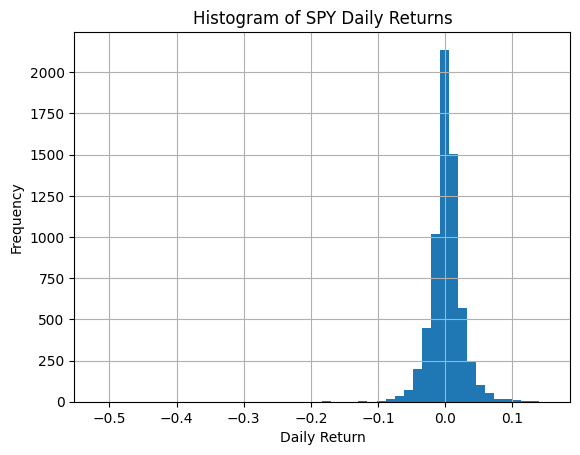

In [10]:
# plot the daily returns on a frequency histogram
import matplotlib.pyplot as plt
hist_spy['Daily Return'].hist(bins=50)
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.title('Histogram of SPY Daily Returns')
plt.show()


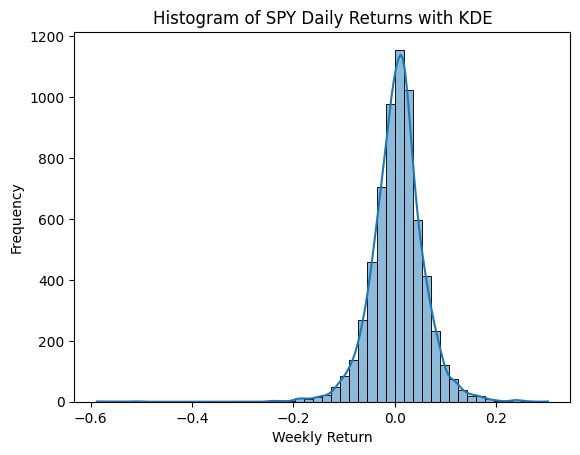

In [11]:
# check if it follows a gaussian mixture model
import seaborn as sns
sns.histplot(hist_spy['Weekly Return'].dropna(), bins=50, kde=True)
plt.xlabel('Weekly Return')
plt.ylabel('Frequency')
plt.title('Histogram of SPY Daily Returns with KDE')
plt.show()

## Hidden Markov Model

In [12]:
# use a hidden markov model to fit the data
from hmmlearn.hmm import GaussianHMM
import numpy as np

# fit the model to the weekly returns
model = GaussianHMM(n_components=3, covariance_type="full", n_iter=1000)
# reshape the data
returns = hist_spy['Weekly Return'].dropna().values.reshape(-1, 1)
model.fit(returns)
# predict the hidden states
hidden_states = model.predict(returns)
# add the hidden states to the dataframe
hist_spy = hist_spy.dropna()
hist_spy['Hidden State'] = hidden_states
hist_spy


/var/folders/zk/99phrd0d2fs5xjbc622wn4_h0000gn/T/ipykernel_11090/845976057.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist_spy['Hidden State'] = hidden_states


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Daily Return,Weekly Return,Hidden State
Date,,,,,,,,,,
2000-01-10 00:00:00-05:00,0.765513,0.767389,0.711101,0.733617,505064000,0.0,0.0,-0.017588,-0.126745,1
2000-01-11 00:00:00-05:00,0.720014,0.745813,0.679205,0.696092,441548800,0.0,0.0,-0.051151,-0.095122,1
2000-01-12 00:00:00-05:00,0.712977,0.716731,0.649185,0.654345,976068800,0.0,0.0,-0.059973,-0.161658,1
2000-01-13 00:00:00-05:00,0.709108,0.741121,0.694215,0.726111,1032684800,0.0,0.0,0.109677,0.018421,0
2000-01-14 00:00:00-05:00,0.750503,0.767389,0.745813,0.753786,390376000,0.0,0.0,0.038114,0.009422,0
...,...,...,...,...,...,...,...,...,...,...
2025-09-22 00:00:00-04:00,248.300003,256.640015,248.119995,256.079987,105517400,0.0,0.0,0.043096,0.081876,2
2025-09-23 00:00:00-04:00,255.880005,257.339996,253.580002,254.429993,60275200,0.0,0.0,-0.006443,0.068360,2
2025-09-24 00:00:00-04:00,255.220001,255.740005,251.039993,252.309998,42303700,0.0,0.0,-0.008332,0.055735,2


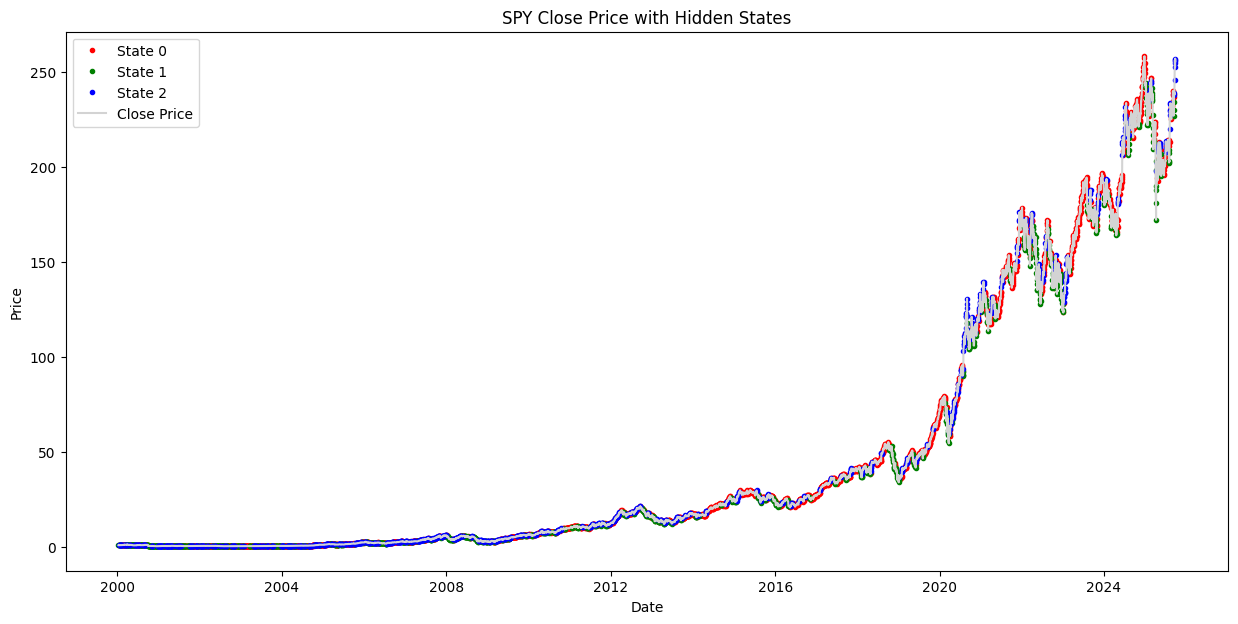

In [13]:
# plot the hidden states as colours on a time series
import matplotlib.pyplot as plt
import numpy as np
# colour each point by its hidden state
colors = np.array(['red', 'green', 'blue'])
plt.figure(figsize=(15, 7))
for i in range(model.n_components):
    state = hist_spy['Hidden State'] == i
    plt.plot(hist_spy.index[state], hist_spy['Close'][state], '.', color=colors[i], label=f'State {i}')
plt.plot(hist_spy.index, hist_spy['Close'], '-', color='lightgrey', label='Close Price')
plt.title('SPY Close Price with Hidden States')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [14]:
# use a hidden markov model to fit the data daily
from hmmlearn.hmm import GaussianHMM
import numpy as np
# print(hist_spy)
hist_spy_train = hist_spy[hist_spy.index < '2020-01-01']
hist_spy_test = hist_spy.loc[(hist_spy.index >= '2020-01-01') & (hist_spy.index < '2025-01-01')]
# fit the model to the weekly returns
model = GaussianHMM(n_components=2, covariance_type="full", n_iter=1000)
# reshape the data
returns = hist_spy_train['Daily Return'].dropna().values.reshape(-1, 1)
# print(returns)
model.fit(returns)
# predict the hidden states
hidden_states = model.predict(returns)
print(hidden_states)
# add the hidden states to the dataframe
hist_spy_train = hist_spy_train.dropna()
hist_spy_train['Hidden State'] = hidden_states
hist_spy_train


Model is not converging.  Current: 12176.989024519879 is not greater than 12176.991093487886. Delta is -0.002068968007733929


[0 0 0 ... 1 1 1]


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Daily Return,Weekly Return,Hidden State
Date,,,,,,,,,,
2000-01-10 00:00:00-05:00,0.765513,0.767389,0.711101,0.733617,505064000,0.0,0.0,-0.017588,-0.126745,0
2000-01-11 00:00:00-05:00,0.720014,0.745813,0.679205,0.696092,441548800,0.0,0.0,-0.051151,-0.095122,0
2000-01-12 00:00:00-05:00,0.712977,0.716731,0.649185,0.654345,976068800,0.0,0.0,-0.059973,-0.161658,0
2000-01-13 00:00:00-05:00,0.709108,0.741121,0.694215,0.726111,1032684800,0.0,0.0,0.109677,0.018421,0
2000-01-14 00:00:00-05:00,0.750503,0.767389,0.745813,0.753786,390376000,0.0,0.0,0.038114,0.009422,0
...,...,...,...,...,...,...,...,...,...,...
2019-12-24 00:00:00-05:00,68.756422,68.804728,68.328946,68.654984,48478800,0.0,0.0,0.000951,0.013766,1
2019-12-26 00:00:00-05:00,68.787819,70.034028,68.758838,70.017120,93121200,0.0,0.0,0.019840,0.036355,1
2019-12-27 00:00:00-05:00,70.309331,70.997645,69.584791,69.990532,146266000,0.0,0.0,-0.000380,0.034926,1


In [15]:

test_hidden_states = model.predict(hist_spy_test['Daily Return'].dropna().values.reshape(-1, 1))
hist_spy_test = hist_spy_test.dropna()
hist_spy_test['Hidden State'] = test_hidden_states
hist_spy_test


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Daily Return,Weekly Return,Hidden State
Date,,,,,,,,,,
2020-01-02 00:00:00-05:00,71.545860,72.598861,71.292274,72.538483,135480400,0.0,0.0,0.022816,0.056565,0
2020-01-03 00:00:00-05:00,71.765667,72.594055,71.608685,71.833290,146322800,0.0,0.0,-0.009722,0.025939,1
2020-01-06 00:00:00-05:00,70.954188,72.444321,70.703012,72.405678,118387200,0.0,0.0,0.007968,0.034507,1
2020-01-07 00:00:00-05:00,72.415360,72.671364,71.845392,72.065170,108872000,0.0,0.0,-0.004703,0.023566,1
2020-01-08 00:00:00-05:00,71.768086,73.526303,71.768086,73.224411,132079200,0.0,0.0,0.016086,0.032488,1
...,...,...,...,...,...,...,...,...,...,...
2024-12-24 00:00:00-05:00,254.586262,257.296626,254.386957,257.286682,23234700,0.0,0.0,0.011478,0.018621,1
2024-12-26 00:00:00-05:00,257.276679,259.179926,256.718662,258.103729,27237100,0.0,0.0,0.003176,0.044225,1
2024-12-27 00:00:00-05:00,256.917934,257.784882,252.164818,254.685867,42355300,0.0,0.0,-0.013242,0.023219,1


In [16]:
# combine the train and test dataframes
returns = pd.concat([hist_spy_train, hist_spy_test])
returns
hist_spy = returns

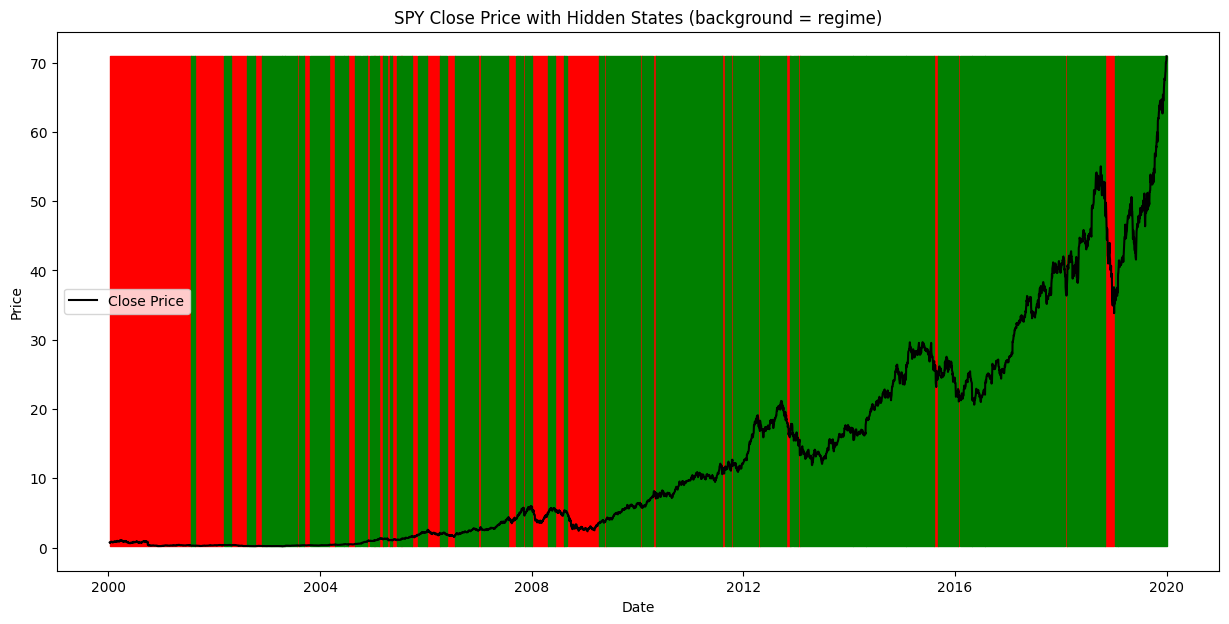

In [17]:
# plot the hidden states as colours on a time series, with background color for regimes
plt.figure(figsize=(15, 7))
# for i in range(model.n_components):
#     state = hist_spy['Hidden State'] == i
#     plt.plot(hist_spy.index[state], hist_spy['Close'][state], '.', color=colors[i], label=f'State {i}')

plt.plot(hist_spy_train.index, hist_spy_train['Close'], '-', color='black', label='Close Price')

# Add background color for each regime
for i in range(model.n_components):
    mask = hist_spy_train['Hidden State'] == i
    plt.fill_between(hist_spy_train.index, hist_spy_train['Close'].min(), hist_spy_train['Close'].max(),
                     where=mask, color=colors[i], alpha=1)

plt.title('SPY Close Price with Hidden States (background = regime)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [18]:
# strategy: buy when entering state 0 (bull market) or 1, sell when entering state 2 (bear market)

class RegimeStrategy(Strategy):
    def init(self):
        pass

    def next(self):
        # Get the current hidden state
        current_state = self.data['Hidden State'][-1]
        # print(self.data)
        # If we are in state 0 or 1 (bull market) and not in a position, buy
        if current_state in [0]:
             # Debugging line to check current state
            if not self.position:
                print(f"Buying at {self.data.index[-1]} in state {current_state}")  # Debugging line
                self.buy()

        # If we are in state 2 (bear market) and in a position, sell
        else:
            if self.position:
                print(f"Selling at {self.data.index[-1]} in state {current_state}")  # Debugging line
                self.position.close()

In [19]:
print(hist_spy_test['Hidden State'].value_counts())
bt = Backtest(hist_spy_test, RegimeStrategy, cash=10_000, commission=0.002, exclusive_orders=True)
stats = bt.run()
print(stats)
fig = bt.plot()

output_file("regime_strategy_AAPL_2020_2024.html")
save(fig)

Hidden State
1    1072
0     186
Name: count, dtype: int64
Buying at 2020-02-21 00:00:00-05:00 in state 0
Selling at 2020-04-15 00:00:00-04:00 in state 1
Buying at 2020-07-23 00:00:00-04:00 in state 0
Selling at 2020-10-14 00:00:00-04:00 in state 1
Buying at 2020-10-28 00:00:00-04:00 in state 0
Selling at 2020-11-06 00:00:00-05:00 in state 1
Buying at 2021-02-25 00:00:00-05:00 in state 0
Selling at 2021-03-10 00:00:00-05:00 in state 1
Buying at 2022-01-28 00:00:00-05:00 in state 0
Selling at 2022-02-01 00:00:00-05:00 in state 1
Buying at 2022-04-26 00:00:00-04:00 in state 0
Selling at 2022-06-17 00:00:00-04:00 in state 1
Buying at 2022-09-12 00:00:00-04:00 in state 0
Selling at 2022-09-14 00:00:00-04:00 in state 1
Buying at 2022-09-29 00:00:00-04:00 in state 0
Selling at 2022-11-11 00:00:00-05:00 in state 1
Buying at 2024-06-11 00:00:00-04:00 in state 0
Selling at 2024-06-13 00:00:00-04:00 in state 1
Start                     2020-01-02 00:00...
End                       2024-12-31 00:

/Users/ivanlee/Developer/financial-data-toolkit/.venv/lib/python3.13/site-packages/bokeh/util/serialization.py:242: UserWarning: no explicit representation of timezones available for np.datetime64
  return convert(array.astype("datetime64[us]"))


'/Users/ivanlee/Developer/financial-data-toolkit/notebooks/regime_strategy_AAPL_2020_2024.html'